In [1]:
import src.dependencies.injector as sdi
from src.shared.logger_factory import LoggerFactory
from src.process.data_cleaning.data_cleaning_distributions import jaccard_similarity
from src.shared.utils import get_project_root
from src.model.cluster import Cluster
from typing import List
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

log = LoggerFactory.logger(__name__)
DEFAULT_PATH = str(get_project_root()) + \
    "/src/scripts/config/create_social_graph_and_cluster_config.yaml"

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'karateclub', 'graph_tool', 'wurlitzer'}
Note: to be able to use all overlapping methods, you need to install some additional packages:  {'ASLPAw', 'karateclub'}
Note: to be able to use all bipartite methods, you need to install some additional packages:  {'infomap', 'leidenalg', 'wurlitzer'}


In [2]:
injector = sdi.Injector.get_injector_from_file(DEFAULT_PATH)
process_module = injector.get_process_module()
dao_module = injector.get_dao_module()
user_activity_getters = {
    "friends": dao_module.get_user_activity_getter(user_activity="friends"),
    "user retweets": dao_module.get_user_activity_getter(user_activity="user retweets"),
    "user retweets ids": dao_module.get_user_activity_getter(user_activity="user retweets ids")
}
user_getter = dao_module.get_user_getter()
user_friend_getter = dao_module.get_user_friend_getter()

def get_user_activities(user_id: str, user_activity: str):
    activities = user_activity_getters[user_activity].get_user_activities(user_id)
    if len(activities) == 0:
        return None
    else:
        return activities

In [4]:
import pickle
seed_user = "hardmaru"
# Load cluster
with open("initial_clusters_hardmaru.pkl", "rb") as f:
    clusters = pickle.load(f)
with open("selected_clusters_2895499182.pkl", "rb") as f:
    selected_clusters = pickle.load(f)

# Print cluster users
for cluster in selected_clusters:
    users = [user_getter.get_user_by_id(user).screen_name for user in cluster.users]
    log.info(users)

2023-06-13 14:58:17 - __main__ - INFO - ['hardmaru', 'DrJimFan', 'peteskomoroch', 'tszzl', 'yaringal', 'JayAlammar', 'PetarV_93', 'mervenoyann', 'mmbronstein', 'ClementDelangue', 'shaneguML', 'Thom_Wolf', 'DynamicWebPaige', 'pabbeel', '_akhaliq', 'srush_nlp', 'egrefen', 'suzatweet', 'sarahookr', 'JeffDean', 'andrewgwils', 'ogrisel', 'colinraffel', 'zacharylipton', 'seb_ruder', 'DaniloJRezende', 'mark_riedl', 'jeremyphoward', 'natashajaques', 'thomaskipf', 'ch402', 'sleepinyourhat', 'kchonyc', 'jackclarkSF', 'Miles_Brundage', '_rockt', 'deliprao', 'janexwang', 'ericjang11', 'shakir_za', 'fchollet', 'karpathy']
2023-06-13 14:58:17 - __main__ - INFO - ['ClementDelangue', 'AlphaSignalAI', 'BlancheMinerva', 'mervenoyann', 'natolambert', 'SashaMTL', 'mmitchell_ai', 'suzatweet', 'l2k', 'mark_riedl', 'clmt', 'SanhEstPasMoi', 'deliprao', 'Miles_Brundage', 'jackclarkSF', 'karpathy', 'seb_ruder', 'fchollet', 'Thom_Wolf', 'sleepinyourhat']


In [5]:
# More ranking experiments
def get_user_ranks(seed_user_name, cluster, path=DEFAULT_PATH):
    """Returns the top 10 ranked users from the given cluster with the seed id as user's id."""
    def get_user_id(user_name):
        user = user_getter.get_user_by_screen_name(user_name)
        user_id = str(user.id)
        return user_id
    user_id = get_user_id(seed_user_name)
    # apply to all users in cluster
    cluster.users = [get_user_id(user_id) for user_id in cluster.users]
    
    injector = sdi.Injector.get_injector_from_file(path)
    process_module = injector.get_process_module()

    prod_ranker = process_module.get_ranker()
    con_ranker = process_module.get_ranker("Consumption")
    sosu_ranker = process_module.get_ranker("SocialSupport")
    infl1_ranker = process_module.get_ranker("InfluenceOne")
    infl2_ranker = process_module.get_ranker("InfluenceTwo")

    # Second argument is the return of score_users
    prod_rank, prod = prod_ranker.rank(user_id, cluster)
    con_rank, con = con_ranker.rank(user_id, cluster)
    sosu_rank, sosu = sosu_ranker.rank(user_id, cluster)
    infl1_rank, infl1 = infl1_ranker.rank(user_id, cluster)
    infl2_rank, infl2 = infl2_ranker.rank(user_id, cluster)

    return sosu, infl1, infl2, prod, con


In [6]:
def get_intersection_ranking(prod, con, infl1, infl2):
    """Produces a ranking that is the intersection of the Production,
    Consumption, Influence One, and Influence Two rankings

    Args:
        prod, con, infl1, infl2:
            Are dictionaries where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    prod_ranking = list(sorted(prod, key=lambda x: (prod[x][0], prod[x][1]), reverse=True))
    con_ranking = list(sorted(prod, key=lambda x: (con[x][0], con[x][1]), reverse=True))
    infl1_ranking = list(sorted(prod, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=True))
    infl2_ranking = list(sorted(prod, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=True))
    top_all = {}
    for i in range(1, len(prod_ranking) + 1):
        top_prod = set(prod_ranking[:i])
        top_con = set(con_ranking[:i])
        top_infl1 = set(infl1_ranking[:i])
        top_infl2 = set(infl2_ranking[:i])
        intersection = top_prod.intersection(
            top_con).intersection(
            top_infl1).intersection(
            top_infl2)

        for user in intersection:
            if user not in top_all:
                top_all[user] = [i, infl2_ranking.index(user)]

        #if len(intersection) >= 20: break
        if len(intersection) >= 10: break

    return sorted(top_all, key=lambda x: (top_all[x][0], top_all[x][1]))

In [7]:
def control_intersection_ranking(sosu, infl1, infl2):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    # Get top 20 users from sosu_ranking
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))[:10]
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=False))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=False))
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    log.info(f"Sosu score cutoff is {sosu[sosu_ranking[-1]][0]}")
    
    return sosu_ranking

In [35]:
def get_new_intersection_ranking(sosu, infl1, infl2):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    # Get top 20 users from sosu_ranking
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=False))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=False))
    # Plot histogram of inflence 1 scores
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
    sns.histplot([infl1[x][0] for x in infl1], ax=axs[0], kde=True, bins=20)
    sns.histplot([infl2[x][0] for x in infl2], ax=axs[1], kde=True, bins=20)
    axs[0].set_title("Influence One")
    axs[1].set_title("Influence Two")
    plt.show()

    sosu_ranking = sosu_ranking[:20]
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    log.info(f"Sosu score cutoff is {sosu[sosu_ranking[-1]][0]}")
    
    # Remove lowest infl1_ranking users from sosu_ranking until 10 users are left
    for user in infl1_ranking:
        if user in sosu_ranking:
            sosu_ranking.remove(user)
        if len(sosu_ranking) <= 10:
            break
    # Influence 1 with users in sosu_ranking
    lst = sorted([infl1[x][0] for x in sosu_ranking])
    print(lst)
            
        
    return sosu_ranking

In [9]:
def get_new_avg_intersection_ranking(sosu, infl1, infl2):
    """Produces a ranking that aggregates the Social Support and Influence One rankings

    Args:
        sosu, infl1:
            Is a dictionary where the key is the user id and the value is their
            score for the respective ranker
    Returns:
        An ordered list of about 10 highest ranked users sorted by highest rank.
    """
    sosu_ranking = list(sorted(sosu, key=lambda x: (sosu[x][0], sosu[x][1]), reverse=True))[:20]
    infl1_ranking = list(sorted(sosu, key=lambda x: (infl1[x][0], infl1[x][1]), reverse=False))
    infl2_ranking = list(sorted(sosu, key=lambda x: (infl2[x][0], infl2[x][1]), reverse=False))
    avg_infl1_infl2 = {user: min(infl1[user][0], infl2[user][0]) for user in infl1}
    avg_infl1_infl2 = list(sorted(avg_infl1_infl2, key=lambda x: (avg_infl1_infl2[x]), reverse=False))
    # Lowest infl1 scores appear first
    # Lowest infl2 scores appear first
    log.info(f"Sosu score cutoff is {sosu[sosu_ranking[-1]][0]}")
    
    # Remove lowest infl1_ranking users from sosu_ranking until 10 users are left
    for user in avg_infl1_infl2:
        if user in sosu_ranking:
            sosu_ranking.remove(user)
        if len(sosu_ranking) == 10:
            break
    return sosu_ranking

In [57]:
# Chess cluster
cluster = ['hardmaru', 'DrJimFan', 'peteskomoroch', 'tszzl', 'yaringal', 'JayAlammar', 'PetarV_93', 'mervenoyann', 'mmbronstein', 'ClementDelangue', 'shaneguML', 'Thom_Wolf', 'DynamicWebPaige', 'pabbeel', '_akhaliq', 'srush_nlp', 'egrefen', 'suzatweet', 'sarahookr', 'JeffDean', 'andrewgwils', 'ogrisel', 'colinraffel', 'zacharylipton', 'seb_ruder', 'DaniloJRezende', 'mark_riedl', 'jeremyphoward', 'natashajaques', 'thomaskipf', 'ch402', 'sleepinyourhat', 'kchonyc', 'jackclarkSF', 'Miles_Brundage', '_rockt', 'deliprao', 'janexwang', 'ericjang11', 'shakir_za', 'fchollet', 'karpathy']
cluster = Cluster("chessable", cluster)
sosu, infl1, infl2, prod, con = get_user_ranks("chessable", cluster)

100%|██████████| 43/43 [00:00<00:00, 62.18it/s]


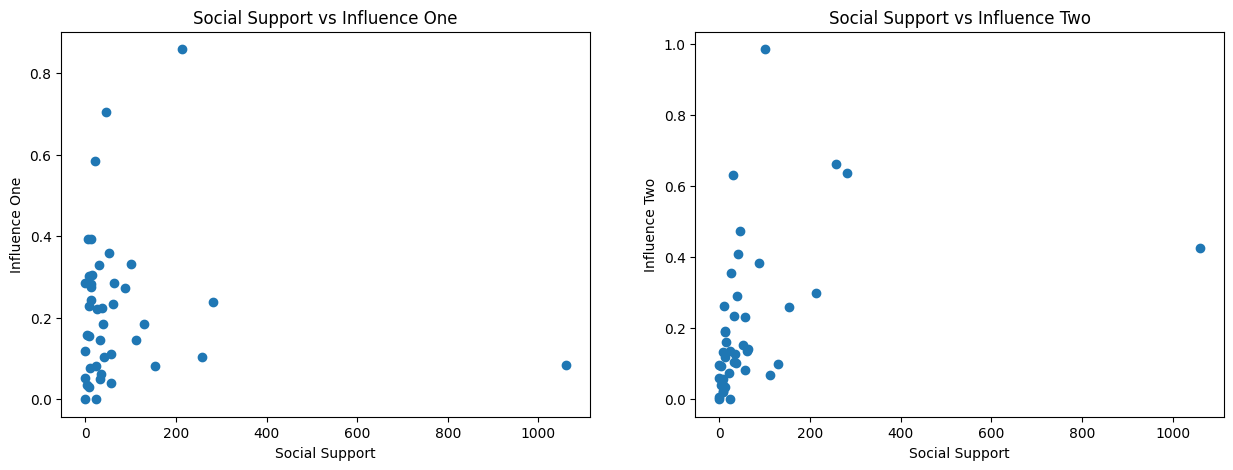

In [58]:
# Plot sosu vs infl1, infl2
fig, (ax1, ax2) = plt.subplots(1, 2)
fig = fig.set_size_inches(15, 5)
ax1.scatter([sosu[user][0] for user in sosu], [infl1[user][0] for user in sosu])
ax1.set_xlabel("Social Support")
ax1.set_ylabel("Influence One")
ax1.set_title("Social Support vs Influence One")
ax2.scatter([sosu[user][0] for user in sosu], [infl2[user][0] for user in sosu])
ax2.set_xlabel("Social Support")
ax2.set_ylabel("Influence Two")
ax2.set_title("Social Support vs Influence Two")
plt.show()

In [59]:
control_sosu_ranking = control_intersection_ranking(sosu, infl1, infl2)
control_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in control_sosu_ranking]
log.info(control_sosu_ranking_names)

2023-06-13 15:31:41 - __main__ - INFO - Sosu score cutoff is 64.0
2023-06-13 15:31:41 - __main__ - INFO - ['DynamicWebPaige', 'hardmaru', '_akhaliq', 'karpathy', 'fchollet', 'mervenoyann', 'DrJimFan', 'ClementDelangue', 'egrefen', 'jackclarkSF']


In [60]:
old_intersection_ranking = get_intersection_ranking(prod, con, infl1, infl2)
old_intersection_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in old_intersection_ranking]
log.info(old_intersection_ranking_names)

2023-06-13 15:31:41 - __main__ - INFO - ['ClementDelangue', 'egrefen', 'hardmaru', 'Thom_Wolf', 'shaneguML', 'JayAlammar', 'sarahookr', 'jackclarkSF', '_rockt', 'ericjang11']


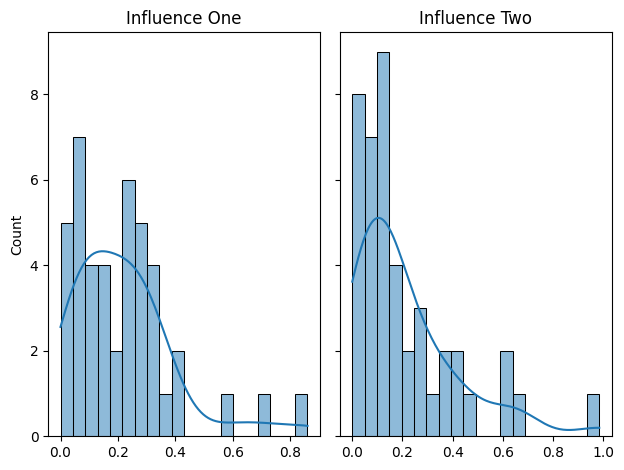

2023-06-13 15:31:42 - __main__ - INFO - Sosu score cutoff is 32.0
2023-06-13 15:31:42 - __main__ - INFO - ['hardmaru', 'karpathy', 'ClementDelangue', 'egrefen', 'jackclarkSF', 'JayAlammar', 'JeffDean', 'Thom_Wolf', 'sarahookr', 'PetarV_93']


[0.18493150684931506, 0.224, 0.23484848484848486, 0.23946360153256704, 0.2725563909774436, 0.2857142857142857, 0.3331907613344739, 0.35909090909090907, 0.7061224489795919, 0.8592375366568915]


In [61]:
new_sosu_ranking = get_new_intersection_ranking(sosu, infl1, infl2)
# Print user names
# Diff only mmitchell_ai removed -- better since theyre not a researcher
new_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in new_sosu_ranking]
log.info(new_sosu_ranking_names)

In [62]:
new_avg_sosu_ranking = get_new_avg_intersection_ranking(sosu, infl1, infl2)
# Print user names
new_avg_sosu_ranking_names = [user_getter.get_user_by_id(user).screen_name for user in new_avg_sosu_ranking]
log.info(new_avg_sosu_ranking_names)

2023-06-13 15:31:42 - __main__ - INFO - Sosu score cutoff is 32.0
2023-06-13 15:31:42 - __main__ - INFO - ['hardmaru', 'karpathy', 'ClementDelangue', 'egrefen', 'jackclarkSF', 'JayAlammar', 'JeffDean', 'Thom_Wolf', 'sarahookr', 'ericjang11']


In [63]:
# Set difference both ways
log.info(set(old_intersection_ranking_names) - set(new_sosu_ranking_names))
log.info(set(new_sosu_ranking_names) - set(new_avg_sosu_ranking_names))
log.info(set(new_avg_sosu_ranking_names) - set(new_sosu_ranking_names))
log.info(set(control_sosu_ranking_names) - set(new_sosu_ranking_names))
log.info(set(control_sosu_ranking_names) - set(new_avg_sosu_ranking_names))

2023-06-13 15:31:42 - __main__ - INFO - {'ericjang11', '_rockt', 'shaneguML'}
2023-06-13 15:31:42 - __main__ - INFO - {'PetarV_93'}
2023-06-13 15:31:42 - __main__ - INFO - {'ericjang11'}
2023-06-13 15:31:42 - __main__ - INFO - {'mervenoyann', '_akhaliq', 'fchollet', 'DrJimFan', 'DynamicWebPaige'}
2023-06-13 15:31:42 - __main__ - INFO - {'mervenoyann', '_akhaliq', 'fchollet', 'DrJimFan', 'DynamicWebPaige'}


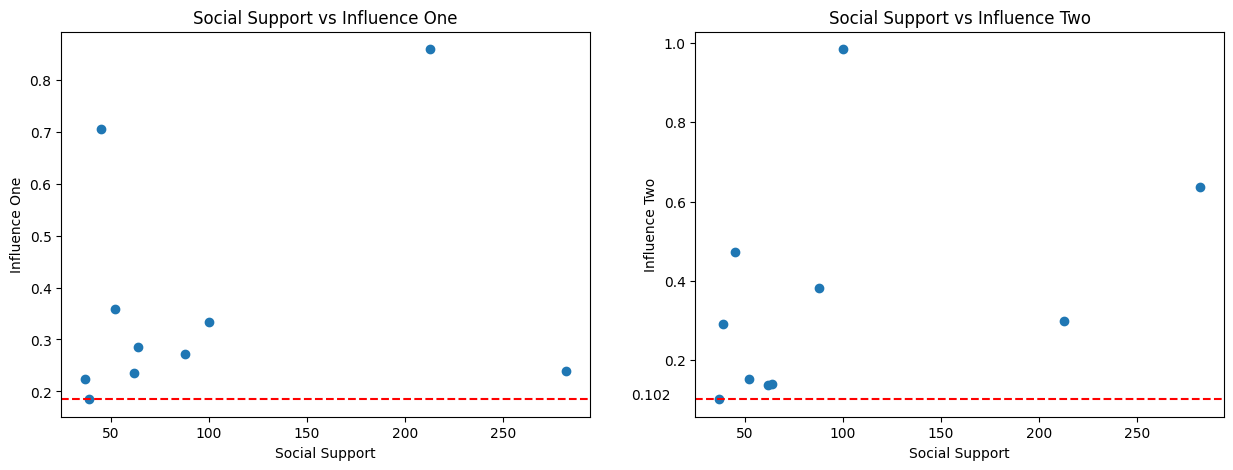

In [64]:
# Plot social support vs infl1 and infl2
fig, (ax1, ax2) = plt.subplots(1, 2)
fig = fig.set_size_inches(15, 5)
ax1.scatter([sosu[user][0] for user in new_sosu_ranking], [infl1[user][0] for user in new_sosu_ranking])
# Plot horizontal line at min infl1 score
min1 = min([infl1[user][0] for user in new_sosu_ranking])
ax1.axhline(y=min1, color='r', linestyle='--')
# Show value of min infl1 score
#ax1.text(-8, min1, f"{min1:.3f}")
ax1.set_xlabel("Social Support")
ax1.set_ylabel("Influence One")
ax1.set_title("Social Support vs Influence One")
ax2.scatter([sosu[user][0] for user in new_sosu_ranking], [infl2[user][0] for user in new_sosu_ranking])
# Plot horizontal line at min infl2 score
min2 = min([infl2[user][0] for user in new_sosu_ranking])
ax2.axhline(y=min2, color='r', linestyle='--')
# Show value of min infl2 score
ax2.text(-8, min2, f"{min2:.3f}")
ax2.set_xlabel("Social Support")
ax2.set_ylabel("Influence Two")
ax2.set_title("Social Support vs Influence Two")
plt.show()